In [68]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from utils import important_channels
import utils

In [ ]:
class FileProcessor:
    def __init__(self, file_path):
        self.raw_data = pd.read_csv(file_path)
        self.feedback_times = self.raw_data[self.raw_data['FeedBackEvent'] == 1]['Time']
        self.feedback_indices = self.feedback_times.index
        self.fs = 200 # sampling frequency
        self.default_channel = important_channels[0] # channel Cz

        # filter the data
        temp = utils.bandpass_filter_all(self.raw_data, highcut=30)
        self.filtered_data = utils.bandpass_filter_all(temp, lowcut=0.2, highcut=10)

        self.extracted_features = self.extract_all_features()

    def is_last_letter(self, feedback_id):
        return feedback_id % 5 == 4

    def get_break_after_feedback(self, feedback_id, channel):
        break_time = 4.5 if self.is_last_letter(feedback_id) else 0.5
        
        t1 = self.feedback_times.iloc[feedback_id] + 1.3 # end of feedback
        t2 = t1 + break_time
        part = self.filtered_data[channel].to_numpy()
        part = part[int(t1*self.fs):int(t2*self.fs)+1]
        part_mean = np.mean(part)

        return break_time, part_mean
    
    def get_erp_segment(self, feedback_id, channel):
        break_time, _ = self.get_break_after_feedback(feedback_id, channel)
        
        t1 = self.feedback_times.iloc[feedback_id] + 1.3 + break_time
        if feedback_id < self.feedback_indices.size - 1:
            t2 = self.feedback_times.iloc[feedback_id + 1]
        else:
            t2 = self.filtered_data['Time'].iloc[-1]
        part = self.filtered_data[channel].to_numpy()
        part = part[int(t1*self.fs):int(t2*self.fs)+1]

        return part
        
    def get_blinking_time(self, feedback_id, channel):
        part = self.get_erp_segment(feedback_id, channel)
        dt = len(part) / self.fs - 2
        if dt <= 6.64:
            return 2.64
        elif dt > 6.64 and dt < 7.78:
            d1 = abs(6.64 - dt)
            d2 = abs(7.78 - dt)
            return 2.64 if d1 < d2 else 5.28
        else:
            return 5.28

    def get_important_parts(self, feedback_id, channel, extra_offset = 0.1):
        erp_segment = self.get_erp_segment(feedback_id, channel)
        data = {}
        data['feedback_id'] = feedback_id
        data['channel'] = channel

        # find the green circle part
        green_end = 1
        data['green_raw'] = erp_segment[:int((green_end+extra_offset)*self.fs)]
        _, break_mean = self.get_break_after_feedback(feedback_id, channel)
        data['green_processed'] = data['green_raw'] - break_mean

        # find the between break part mean to process the blinking part
        between_break_end = 2
        between_break = erp_segment[int(green_end*self.fs):int(between_break_end*self.fs)]
        between_break_mean = np.mean(between_break)

        # find the blinking part
        blinking_time = self.get_blinking_time(feedback_id, channel)
        blinking_start = between_break_end - extra_offset
        blinking_end = blinking_start + blinking_time + extra_offset
        data['blinking_raw'] = erp_segment[int(blinking_start*self.fs):int(blinking_end*self.fs)]
        data['blinking_processed'] = data['blinking_raw'] - between_break_mean

        return data

    def sliding_window(self, feedback_id, channel):
        data = self.get_important_parts(feedback_id, channel)
        blinking_data = data['blinking_processed']
        
        window_time = 0.5
        window_size = int(window_time * self.fs)
        window_step = int(0.25 * self.fs)
        windows = []
        num_windows = (len(blinking_data) - window_size) // window_step + 1
        
        for i in range(num_windows):
            window = {}
            window['signal'] = blinking_data[i*window_step:i*window_step+window_size]
            window['mean'] = np.mean(window['signal'])
            window['peak'] = np.max(window['signal'])
            window['latency'] = np.argmax(window['signal']) / self.fs
            window['amplitude'] = np.max(window['signal']) - np.min(window['signal'])
            windows.append(window)
            
        # not a sliding window but add the green circle part as a window
        green_data = data['green_processed']
        green_window = {
            'signal': green_data,
            'mean': np.mean(green_data),
            'peak': np.max(green_data),
            'latency': np.argmax(green_data) / self.fs,
            'amplitude': np.max(green_data) - np.min(green_data)
        }
        windows.append(green_window)

        return windows
        
    def extract_features(self, feedback_id, verbose=False):
        feature_matrix = []
        for channel in important_channels:
            windows = self.sliding_window(feedback_id, channel)
            channel_mean = []            
            channel_peak = []
            channel_latency = []
            channel_amplitude = []

            for w in windows:
                channel_mean.append(w['mean'])
                channel_peak.append(w['peak'])
                channel_latency.append(w['latency'])
                channel_amplitude.append(w['amplitude'])
            feature_matrix.append(channel_mean)
            feature_matrix.append(channel_peak)
            feature_matrix.append(channel_latency)
            feature_matrix.append(channel_amplitude)

            if verbose: print(f'Channel {channel} with {len(windows)} windows')

        return np.array(feature_matrix).T
    
    def extract_all_features(self, verbose=False):
        features = []
        for id in range(self.feedback_indices.size-1):
            temp = self.extract_features(id)
            if verbose: print(f'shape for id {id} is {temp.shape}')
            features.append(temp)

        features = np.vstack(features)
        if verbose: print(f'Final shape: {features.shape}')
        return features

In [84]:
class SubjectData:
    def __init__(self, subject_name = "06"):
        self.subject_name = subject_name
        self.raw_features = []
        for i in range(1, 6):
            file_path = f'data/train/Data_S{subject_name}_Sess0{i}.csv'
            fp = FileProcessor(file_path)
            self.raw_features.append(fp.extracted_features)
        self.raw_features = np.vstack(self.raw_features)

    def cluster_features(self):
        """ Apply PCA and then K-Means clustering to classify P300 vs non-P300 windows """
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(self.raw_features)  # Normalize features
        
        pca = PCA(n_components=3)  # Reduce to 3D for better clustering
        features_pca = pca.fit_transform(features_scaled)
        
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        labels = kmeans.fit_predict(features_pca)
        
        return labels, features_pca
    
    def dbscan_features(self, pca_components=3, eps=0.5):
        """ Apply PCA and then DBSCAN clustering to classify P300 vs non-P300 windows """
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(self.raw_features)

        pca = PCA(n_components=pca_components)
        features_pca = pca.fit_transform(features_scaled)

        dbscan = DBSCAN(eps=eps, min_samples=5)
        labels = dbscan.fit_predict(features_pca)

        return labels, features_pca

In [ ]:
fp = FileProcessor('data/train/Data_S06_Sess05.csv')

In [72]:
sd = SubjectData(subject_name="06")
print(sd.raw_features.shape)

(4659, 64)


In [56]:
labels, features_pca = sd.cluster_features()
print(labels.shape)
print(features_pca.shape)

(4659,)
(4659, 5)


In [82]:
labels, features_pca = sd.dbscan_features(pca_components=5, eps=0.5)

s, counts = np.unique(labels, return_counts=True)
for label, count in zip(s, counts):
    print(f"Label {label}: {count} occurrences")

Label -1: 2037 occurrences
Label 0: 2482 occurrences
Label 1: 6 occurrences
Label 2: 13 occurrences
Label 3: 3 occurrences
Label 4: 4 occurrences
Label 5: 9 occurrences
Label 6: 4 occurrences
Label 7: 3 occurrences
Label 8: 5 occurrences
Label 9: 5 occurrences
Label 10: 7 occurrences
Label 11: 5 occurrences
Label 12: 16 occurrences
Label 13: 5 occurrences
Label 14: 5 occurrences
Label 15: 5 occurrences
Label 16: 5 occurrences
Label 17: 5 occurrences
Label 18: 7 occurrences
Label 19: 3 occurrences
Label 20: 6 occurrences
Label 21: 5 occurrences
Label 22: 5 occurrences
Label 23: 5 occurrences
Label 24: 4 occurrences


In [114]:
# Find the cluster with the highest mean amplitude
unique_labels = np.unique(labels)
cluster_means = {label: sd.raw_features[labels == label].mean(axis=0) for label in unique_labels if label != -1}
#print(cluster_means)

# Sort clusters by mean amplitude (assuming amplitudes are at indexes 3, 7, 11, ...)
sorted_clusters = sorted(cluster_means.items(), key=lambda x: np.mean(x[1][3::4]), reverse=True)

l = len(unique_labels)
top_percentage = 0.3
stop = int(l*top_percentage)
print(f'l={l}, top={top_percentage}, stop={stop}')

# Select top N clusters as P300
p300_labels = [cluster[0] for cluster in sorted_clusters[:stop]]  # Adjust 3 as needed
print("P300 Clusters:", p300_labels)
    
# Convert labels into binary classes (1 = P300, 0 = Non-P300)
binary_labels = np.zeros_like(labels)
c = 0
for i in range(len(labels)):
    if labels[i] in p300_labels:
        binary_labels[i] = 1
        c += 1
print(f'Found {c}/{len(labels)} ({(c/len(labels)*100):.2f}%) P300 segments')
print(binary_labels.shape)

l=26, top=0.3, stop=7
P300 Clusters: [21, 19, 13, 24, 0, 4, 2]
Found 2516/4659 (54.00%) P300 segments
(4659,)


In [90]:
p300_label = max(cluster_means, key=lambda label: cluster_means[label][3])  # Assuming amplitude is 2nd feature
non_p300_label = min(cluster_means, key=lambda label: cluster_means[label][3])  

print(f"P300 cluster: {p300_label}, Non-P300 cluster: {non_p300_label}")

# Convert labels into binary classes
binary_labels = np.where(labels == p300_label, 1, 0)

P300 cluster: 21, Non-P300 cluster: 1


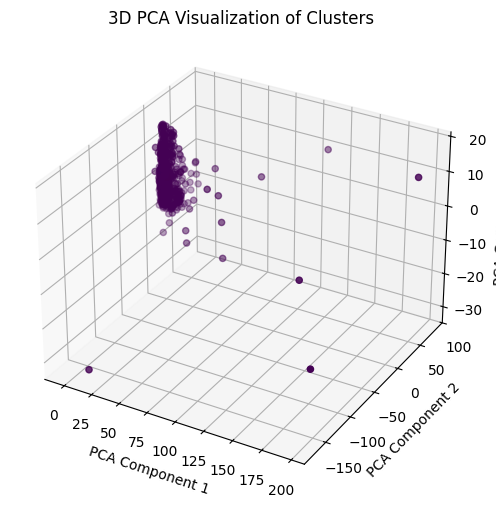

In [76]:
%matplotlib inline
# 3D Scatter plot of PCA components
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c=labels, cmap='viridis', marker='o')
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("3D PCA Visualization of Clusters")
plt.show()